In [64]:
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from Pneumonia_predictor import PneumoniaPredictorCNN, PneumoniaDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [65]:
model =PneumoniaPredictorCNN()
model.load_state_dict(torch.load('output/models/best_model.pth'))
model.eval()



Flattened size after conv layers: 23040  160 channels x 12 H x 12 W)


PneumoniaPredictorCNN(
  (layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 96, kernel_size=(5, 5), stride=(1, 1))
    (9): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(96, 128, kernel_size=(5, 5), stride=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stri

In [66]:
test_data_df = pd.read_csv(f'data/test_data.csv')
test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


test_dataset = PneumoniaDataset(test_data_df, transform=test_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=5, shuffle=True)

classes = ['Normal', 'Pneumonia']

In [67]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)


tensor([1, 1, 1, 1, 0])


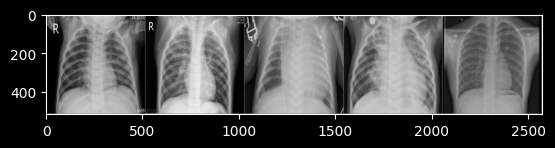

GroundTruth:  Pneumonia Pneumonia Pneumonia Pneumonia Normal
Predicted:  Pneumonia Pneumonia Pneumonia Pneumonia Pneumonia


In [72]:
images, labels = next(dataiter)
print(labels)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))

outputs = model(images)

_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(5)))

In [73]:
ind = 4

input = images[ind].unsqueeze(0)
input.requires_grad = True


In [74]:
def attribute_image_features(algorithm,input, model, **kwargs ):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target= labels[ind],
                                              **kwargs)
    return tensor_attributions

ig = IntegratedGradients(model)
attr_ig, delta = attribute_image_features(ig, input, model, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
print(f'Approximation delta: {delta.item()}')

Approximation delta: 0.0009157554286514102


Original Image
GroundTruth: Normal
Predicted: Pneumonia  Probability: 0.9986696243286133


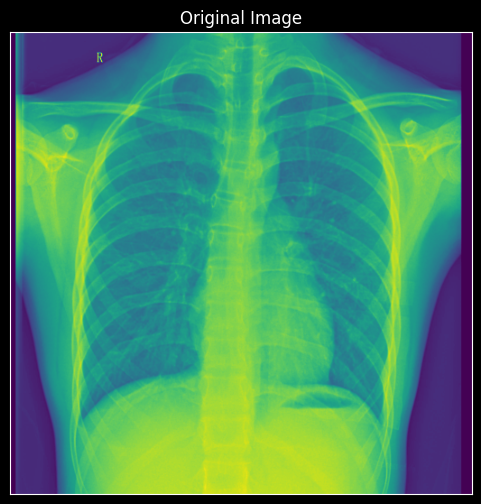

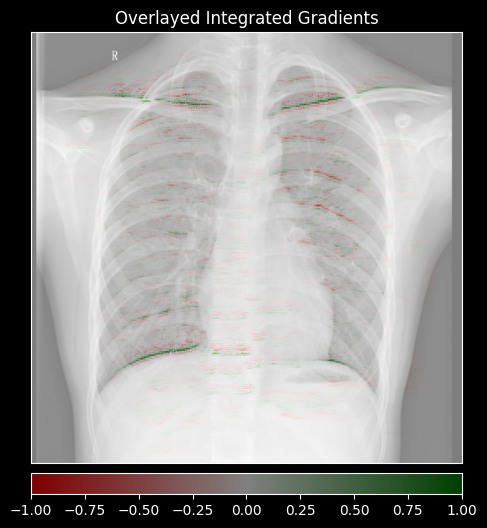

In [75]:
original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
print('Original Image')
print('GroundTruth:', classes[labels[ind]])
print('Predicted:', classes[predicted[ind]], 
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

_ = viz.visualize_image_attr(np.zeros_like(original_image), original_image, 
                      method="original_image", title="Original Image", cmap="gray")

_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")